## Segmentation of Cell Nuclei Using Otsu Thresholding

### 1. Introduction

Accurate segmentation of cell nuclei in fluorescence microscopy images is an essential step in many biomedical image analysis pipelines. Manual segmentation is impractical for large datasets, as it is time-consuming, subjective, and non-reproducible. Automated thresholding methods such as **Otsu’s method** provide an efficient way to segment cell nuclei by automatically selecting an intensity threshold that separates foreground (nuclei) from background.

In this project, we implemented and evaluated **global** and **local Otsu thresholding methods** for cell nuclei segmentation, as required by Project 3 of the Biomedical Image Analysis topic. Furthermore, we applied these methods to three different microscopy datasets:

- **N2DH-GOWT1**: GFP-labeled mouse embryonic stem cells.
- **N2DL-HeLa**: H2B-GFP-labeled HeLa cells.
- **NIH3T3**: Mouse fibroblast cells with challenging bright artifacts.

### 2. Objectives

The main objectives of our work were:

- To implement global Otsu thresholding for cell nuclei segmentation.
- To extend the implementation to local Otsu thresholding using a sliding window approach.
- To quantitatively evaluate the segmentation performance using the Dice coefficient against manually annotated ground-truth masks.
- To verify our implementations by comparing them to the `scikit-image` package.
- To investigate the application of Multi-Otsu thresholding on the NIH3T3 dataset to reduce the effect of extreme brightness artifacts (“flashes”).
- To investigate the enhancement of our output by implementig pre processing methods.

### 3. Notebook Structure

The notebook is organized as follows:

1. **Environment Setup**: Configuration for reproducibility and importing necessary modules.
2. **Loading Images & Ground Truth**: Reading representative images and masks from all datasets.
3. **Global and Local Thresholding**: Applying both our implementations and package methods.
4. **Dice Score Computation**: Calculating scores for quantitative assessment.
5. **Extended Analysis with Multi-Otsu**: Addressing artifacts in NIH3T3 with multi-thresholding.
6. **Extended Analysis with pre prcessing**: Applying and analysing Otsu outputs of multiple pre processing methods.
6. **Results & Visualization**: Presenting outcomes using comparative plots.
7. **Conclusion**: Summarizing findings and practical insights.


## 1. Environment Setup

In this section, we configure the environment to ensure that our custom Python modules can be imported from anywhere in the notebook. By dynamically setting the project root and adding it to the Python path, we guarantee reproducibility and avoid path-related import errors. This setup is essential for maintaining a clean, modular, and portable project structure.

In [46]:
import os
import sys

# Set the project root so we can import our custom modules from anywhere in the notebook
script_dir = os.getcwd()
project_root = os.path.abspath(script_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 2. Loading Images & Ground Truth

To perform a meaningful evaluation of our segmentation algorithms, it is essential to work with representative images from each of the three datasets provided: GOWT1, HeLa, and NIH3T3. This section demonstrates how we load and visualize both the raw images and their corresponding manually segmented ground truth masks.

**Loading and Visualizing Raw Images**

First, we use the custom utility `find_and_load_image` to locate and load representative grayscale images from each dataset. By plotting these side by side, we gain a visual overview of the differences in appearance and image quality between the datasets, which is critical for understanding the challenges of automated segmentation.

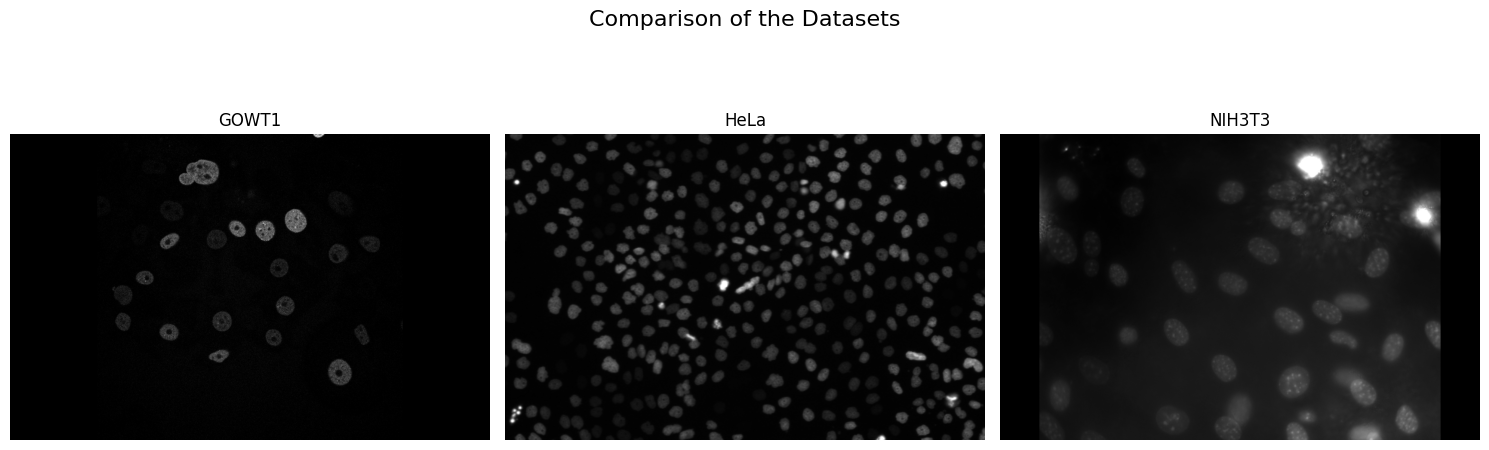

In [47]:
from src.find_image import find_and_load_image

img_gowt1 = find_and_load_image("t01.tif")
img_hela = find_and_load_image("t75.tif")
img_nih3t3 = find_and_load_image("dna-33.png")


from src.show_imgs import plot_images_fixed_size

images_img = [img_gowt1, img_hela, img_nih3t3]
titles_img = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_img, titles=titles_img, main_title="Comparison of the Datasets")

**Loading and Visualizing Ground Truth Masks**

Next, we load the corresponding ground truth masks for the previously loaded images. These masks represent the expert-annotated segmentation of the cell nuclei and serve as the reference for evaluating our segmentation methods. Plotting the masks alongside the original images provides an immediate qualitative impression of the segmentation targets in each dataset.

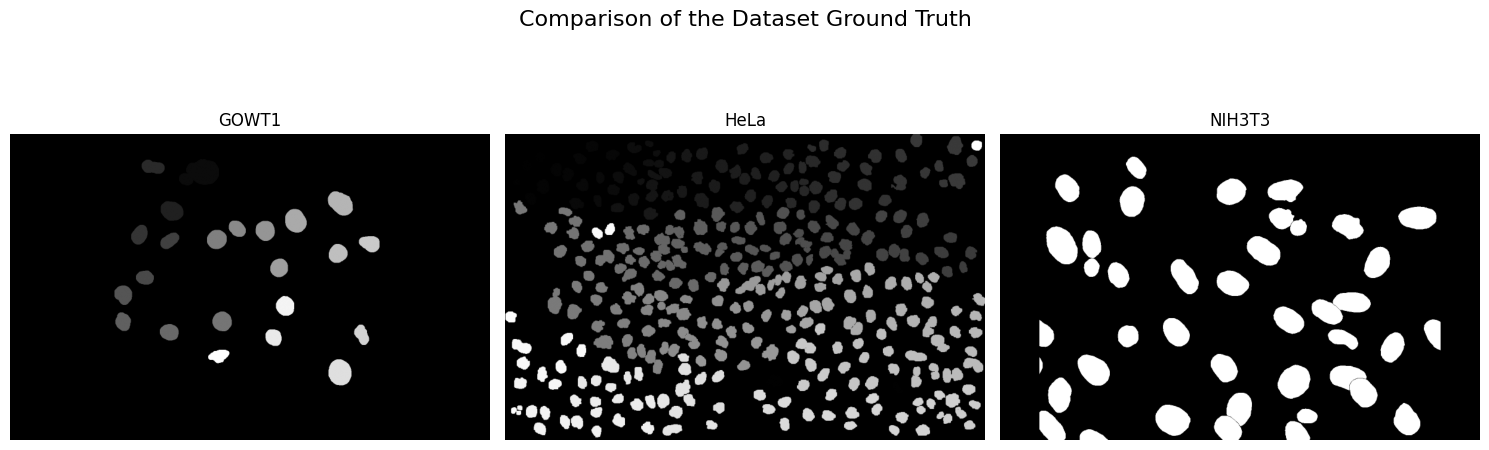

In [48]:
gt_gowt1 = find_and_load_image("man_seg01.tif")
gt_hela = find_and_load_image("man_seg75.tif")
gt_nih3t3 = find_and_load_image("33.png")


images_gt = [gt_gowt1, gt_hela, gt_nih3t3]
titles_gt = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_gt, titles = titles_gt, main_title = "Comparison of the Dataset Ground Truth")

## 3. Global and Local Thresholding

In this section, we apply both our own implementations and standard package methods for global and local thresholding, key techniques for segmenting cell nuclei based on intensity differences.

**Global Otsu Thresholding (Our Implementation)**

We first apply our own implementation of Otsu’s global thresholding algorithm (`otsu_threshold_skimage_like`) on a representative GOWT1 image. This method automatically finds an optimal global threshold value that separates foreground (cell nuclei) from background based on maximizing inter-class variance in the grayscale histogram. The result is then compared against the ground truth.

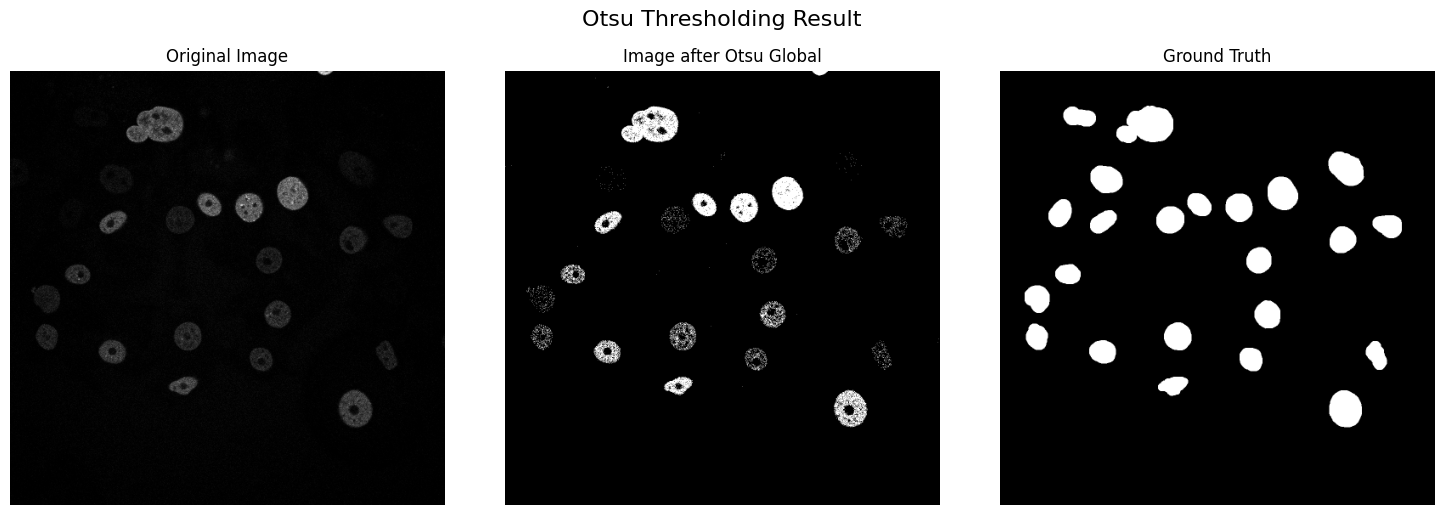

In [49]:
from src.Complete_Otsu_Global import otsu_threshold_skimage_like

threshold = otsu_threshold_skimage_like(img_gowt1)
img_gowt1_otsu_global = (img_gowt1 > threshold).astype(int)


plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_global, (gt_gowt1 > 0).astype(int)],
    titles=["Original Image", "Image after Otsu Global", "Ground Truth"],
    main_title="Otsu Thresholding Result"
)

**Local Otsu Thresholding (Our Implementation)**

To handle images with non-uniform illumination, we extend Otsu’s method to a local variant using our own `local_otsu` implementation. This technique calculates a local threshold for each pixel within a sliding window, resulting in better segmentation performance in challenging images with shading artifacts or heterogeneous lighting.

**Important Note:** This implementation is computationally intensive and takes a long time to run on high-resolution images. Therefore, it may not be practical for quick notebook execution or large-scale datasets.

In [133]:
# takes very long

from src.Otsu_Local import local_otsu

thresholds_local = local_otsu(img_gowt1, radius = 15)
img_gowt1_otsu_local = (img_gowt1 > thresholds_local).astype(int)


plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_local],
    titles=["Original Image", "Image after Otsu Local"],
    main_title="Local Otsu Thresholding Result\n(Radius = 15)"
)

Processing row 1/1024...


KeyboardInterrupt: 

**Local Otsu Thresholding (Package Method for Efficiency)**

For faster prototyping and visualization, we provide an alternative using the `threshold_local` function from the `skimage` library. While this method does not implement Otsu's local thresholding but a local mean threshold, it produces comparable segmentation results much faster. 

**Caution:** You should only execute either the custom local implementation (slow) or the package-based method (fast) — not both — because both define the same variable `img_gowt1_otsu_local`, which can cause conflicts during notebook execution.

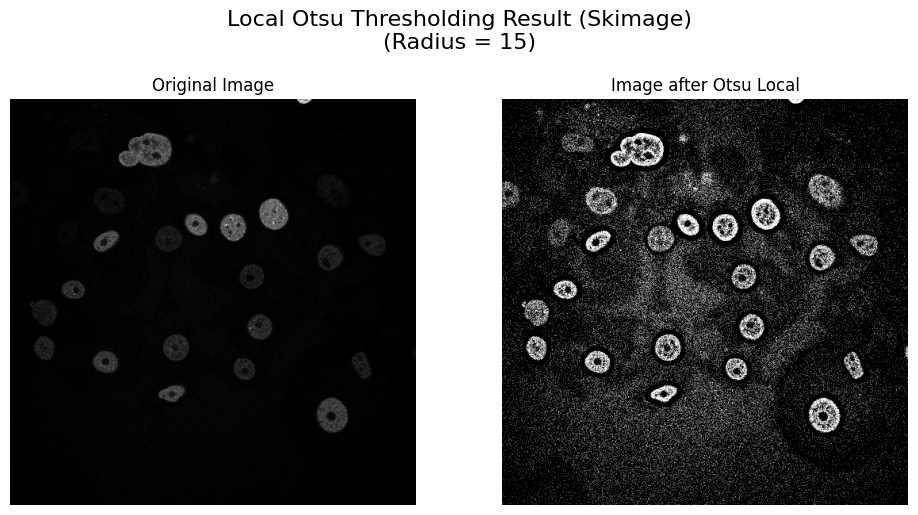

In [50]:
# Package Otsu Local for visualisation for time efficiency
import importlib
import src.Otsu_Local


importlib.reload(src.Otsu_Local)
from src.Otsu_Local import local_otsu_package

thresholds_local = local_otsu_package(img_gowt1, radius=15)
img_gowt1_otsu_local = (img_gowt1 > thresholds_local).astype(int)

plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_local],
    titles=["Original Image", "Image after Otsu Local"],
    main_title="Local Otsu Thresholding Result (Skimage)\n(Radius = 15)"
)

## 4. Dice Score Computation

In this section, we compute Dice scores to quantitatively evaluate the performance of the global and local Otsu segmentation methods with `dice_score`. The Dice coefficient measures the overlap between the predicted segmentation mask and the ground truth, providing a score between 0 (no overlap) and 1 (perfect match).

**Single Image Dice Score Computation:**

We begin by computing Dice scores for a single representative image (GOWT1) using both the global and local Otsu thresholding results. This provides an immediate indication of how each segmentation method performs on an example case before applying them across the full datasets.


In [51]:

from src.Dice_Score import dice_score

dice_score_gowt1_global = dice_score(img_gowt1_otsu_global, gt_gowt1) 

dice_score_gowt1_local = dice_score(img_gowt1_otsu_local, gt_gowt1)


print("Dice Score Otsu Global:", dice_score_gowt1_global)
print("Dice Score Otsu Local:", dice_score_gowt1_local)

Dice Score Otsu Global: 0.5705017182130584
Dice Score Otsu Local: 0.3928938710856586


**Loading All Dataset Images:**

Next, we load all images and their corresponding ground truth masks from the three datasets (N2DH-GOWT1, N2DL-HeLa, NIH3T3) with the funktions `load_n2dh_gowt1_images`,`load_n2dl_hela_images` and `load_nih3t3_images`. Access to the complete data is essential for a robust, dataset-wide evaluation of segmentation performance.

In [52]:
# Imports from project-specific src/ directory
from src.imread_all import load_n2dh_gowt1_images, load_n2dl_hela_images, load_nih3t3_images


# Load images and ground-truth masks from the datasets
imgs_N2DH_GOWT1, gts_N2DH_GOWT1, img_paths_N2DH_GOWT1, gt_paths_N2DH_GOWT1 = load_n2dh_gowt1_images()
imgs_N2DL_HeLa, gts_N2DL_HeLa, img_paths_N2DL_HeLa, gt_paths_N2DL_HeLa = load_n2dl_hela_images()
imgs_NIH3T3, gts_NIH3T3, img_paths_NIH3T3, gt_paths_NIH3T3 = load_nih3t3_images()

**Global Otsu Dice Scores on All Datasets:**

We then calculate Dice scores across the entire datasets using our own global Otsu implementation. Using the `calculate_dice_scores_global`function we produces a distribution of Dice scores reflecting the performance of global thresholding on each dataset.

In [71]:
from src.Dice_Score_comparison import calculate_dice_scores_global

# Compute Dice scores for each dataset
dice_all_gowt1_global = calculate_dice_scores_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_global = calculate_dice_scores_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_global = calculate_dice_scores_global(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_all_gowt1_global = [float(score) for score in dice_all_gowt1_global]
dice_all_hela_global = [float(score) for score in dice_all_hela_global]
dice_all_nih_global = [float(score) for score in dice_all_nih_global]

# vector with all Dice scores with our Otsu Global
dice_all_global = dice_all_gowt1_global + dice_all_hela_global + dice_all_nih_global

# Print scores in a readable format
print("GOWT1_Scores_global =\n", list(dice_all_gowt1_global))
print("HeLa_Scores_global =\n", list(dice_all_hela_global))
print("NIH3T3_Scores_global =\n", list(dice_all_nih_global))

GOWT1_Scores_global =
 [0.5705017182130584, 0.32258217915948406, 0.568002229254991, 0.6271474725294504, 0.6502180828858916, 0.6615248976783192]
HeLa_Scores_global =
 [0.6923060104510571, 0.649295517879001, 0.7760944676315427, 0.7761119912979735]
NIH3T3_Scores_global =
 [0.9128436675562167, 0.8845252721173281, 0.8225479821936802, 0.758336987687637, 0.7528567225654604, 0.647632667167185, 0.6466958730507323, 0.7237186625334818, 0.03500481623642597, 0.46518566600901357, 0.0, 0.6762501531852865, 0.00026339009389856846, 0.5757554586315079, 0.6165448260228947, 0.07605520913993832, 0.07186834004262373, 0.7925039681767514]


**Local Otsu Dice Scores on All Datasets (Our Implementation):**

To compare with the global approach, we also compute Dice scores across all images using our own implementation of local Otsu thresholding with the function `calculate_dice_scores_local`.
**Note**: This step can be very time-consuming due to the computational complexity of sliding-window thresholding. May consider using **Local Otsu Dice Scores on All Datasets (Package Implementation)**.


In [ ]:
# takes very long
from src.Dice_Score_comparison import calculate_dice_scores_local

# Compute Dice scores for each dataset
dice_all_gowt1_local = calculate_dice_scores_local(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_local = calculate_dice_scores_local(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_local = calculate_dice_scores_local(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_all_gowt1_local = [float(score) for score in dice_all_gowt1_local]
dice_all_hela_local = [float(score) for score in dice_all_hela_local]
dice_all_nih_local = [float(score) for score in dice_all_nih_local]

# vector with all Dice scores with our Otsu local (radius 15)
dice_all_local = dice_all_gowt1_local + dice_all_hela_local + dice_all_nih_local

# Print scores in a readable format
print("GOWT1_Scores_local =\n", list(dice_all_gowt1_local))
print("HeLa_Scores_local =\n", list(dice_all_hela_local))
print("NIH3T3_Scores_local =\n", list(dice_all_nih_local))

Processing row 1/1024...


KeyboardInterrupt: 

**Local Otsu Dice Scores on All Datasets (Package Implementation):**

For time efficiency, we provide an alternative that uses the `skimage` package’s `threshold_local` function. This method generates comparable Dice scores much faster. 
**Important**: Either the previous implementation of local Otsu or this package-based method should be run **but not both** since they create variables with identical names, which would overwrite each other and potentially cause confusion or errors in subsequent analysis.


In [70]:
# Package Otsu Local for visualisation for time efficiency
from src.Dice_Score_comparison import calculate_dice_scores_local_package

# Compute Dice scores for each dataset
dice_all_gowt1_local = calculate_dice_scores_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_local = calculate_dice_scores_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_local = calculate_dice_scores_local_package(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_all_gowt1_local = [float(score) for score in dice_all_gowt1_local]
dice_all_hela_local = [float(score) for score in dice_all_hela_local]
dice_all_nih_local = [float(score) for score in dice_all_nih_local]

# vector with all Dice scores with our Otsu local (radius 15)
dice_all_local = dice_all_gowt1_local + dice_all_hela_local + dice_all_nih_local

# Print scores in a readable format
print("GOWT1_Scores_local =\n", list(dice_all_gowt1_local))
print("HeLa_Scores_local =\n", list(dice_all_hela_local))
print("NIH3T3_Scores_local =\n", list(dice_all_nih_local))

GOWT1_Scores_local =
 [0.3928938710856586, 0.1366234241552535, 0.35308932019827177, 0.37958763637688286, 0.45346521119334493, 0.512706021406527]
HeLa_Scores_local =
 [0.07436694813419911, 0.12357364181457739, 0.4032134810257176, 0.4112803223656655]
NIH3T3_Scores_local =
 [0.2516608996151936, 0.2819358044796762, 0.38935031887402305, 0.3909447166178474, 0.0, 0.0, 0.41383855174458967, 0.4591994557788203, 0.3785416682047837, 0.3340522332504619, 0.0, 0.35454785700557373, 0.32226630962386715, 0.4702937019148868, 0.35733231552654593, 0.3391168161544625, 0.29237266345322893, 0.4571401303760328]


## 5. Extended Analysis with Multi-Otsu

In this section, we investigate the use of Multi-Otsu thresholding as a potential strategy to address artifacts in the NIH3T3 dataset, specifically, the bright "flashes" observed in some images. These artifacts can disrupt standard Otsu thresholding by skewing the histogram, leading to poor segmentation results.

To explore this, we apply Multi-Otsu thresholding with three classes to separate the image into dark background (class 0), an intermediate intensity range (class 1), and bright artifacts (class 2). We then designate only class 1 (foreground nuclei) as the actual object of interest while treating both class 0 and class 2 as background (`apply_multiotsu_mask_class1`). This approach effectively excludes extreme intensity values (flashes) from the foreground mask.

We visualize the original NIH3T3 image, the Multi-Otsu segmentation result, the global Otsu segmentation result for comparison, and the ground truth side by side to qualitatively assess the differences.

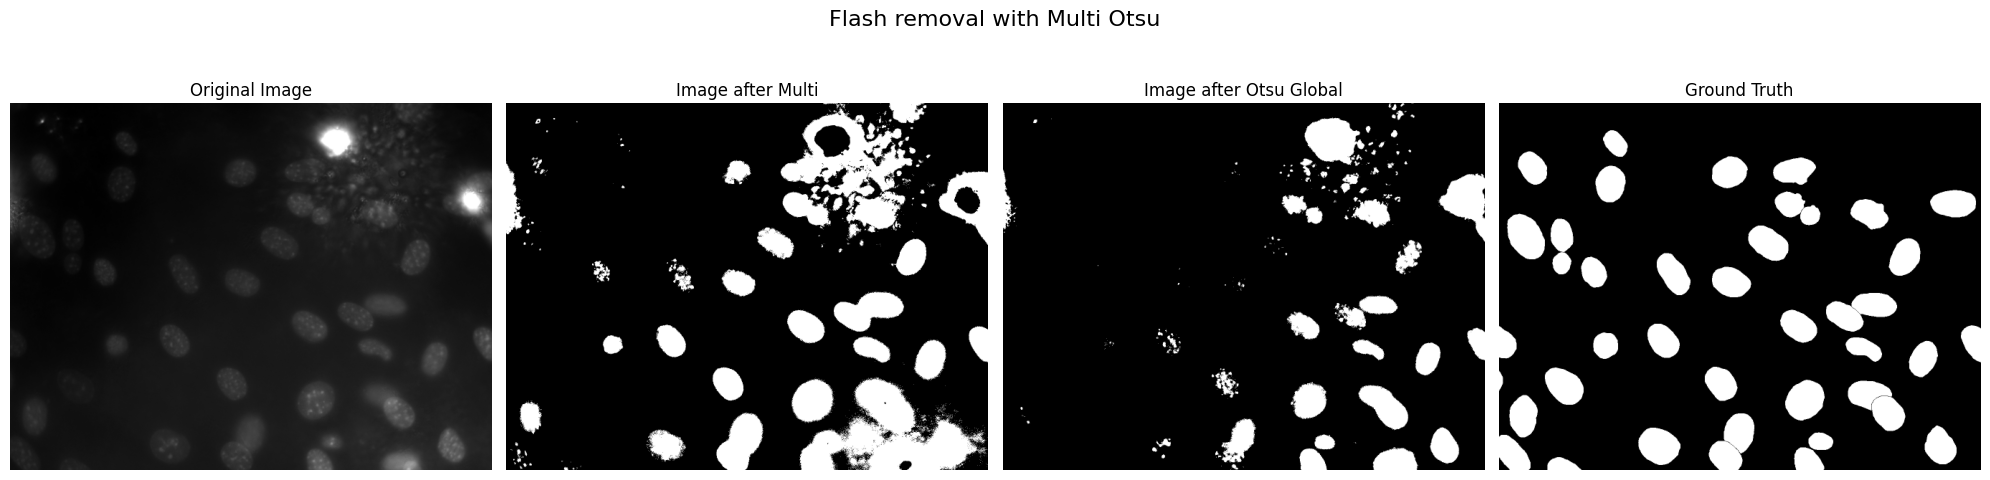

In [55]:
from src.multi import apply_multiotsu_mask_class1


img_nih3t3_multi = apply_multiotsu_mask_class1(img_nih3t3).astype(int)
threshold_nih3t3_global = otsu_threshold_skimage_like(img_nih3t3)

img_nih3t3_otsu_global = (img_nih3t3 > threshold_nih3t3_global).astype(int)

plot_images_fixed_size(
    images=[img_nih3t3, img_nih3t3_multi,img_nih3t3_otsu_global, gt_nih3t3],
    titles=["Original Image", "Image after Multi", "Image after Otsu Global", "Ground Truth"],
    main_title = "Flash removal with Multi Otsu"
)

After generating the segmentations, we quantitatively evaluate the Multi-Otsu approach on the entire NIH3T3 dataset by computing Dice scores for all images. We plot these Dice scores against those obtained from our global Otsu implementation using a scatter plot. Points are colored to indicate whether Multi-Otsu performed better (green), worse (red), or similarly (blue) compared to global Otsu thresholding.

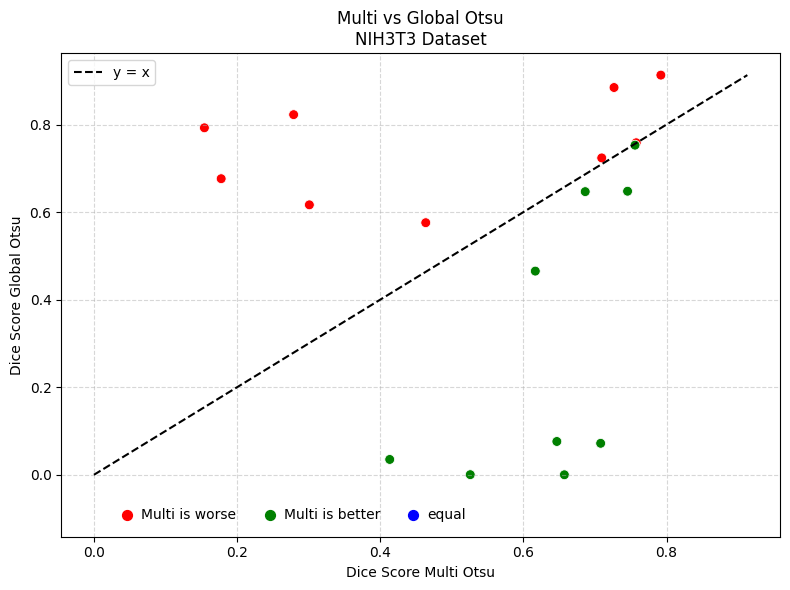

In [56]:
from src.Plots import scatterplot_without_regression
from src.multi import calculate_multiotsu_dice_scores_class1

dice_all_nih_multi = calculate_multiotsu_dice_scores_class1(imgs_NIH3T3, gts_NIH3T3)

scatterplot_without_regression(
    dice_all_nih_multi,
    dice_all_nih_global,
    xlabel="Dice Score Multi Otsu",
    ylabel="Dice Score Global Otsu",
    title="Multi vs Global Otsu\nNIH3T3 Dataset",
    label_red = "Multi is worse",
    label_green = "Multi is better",
    label_blue = "equal"
)

The results showed that Multi-Otsu thresholding did not lead to consistent improvements; in many cases, it even degraded the segmentation performance due to misclassification of true nuclei pixels as background when intensities overlapped with those of artifacts.
Beacause of that we explored two refinements aiming to mitigate the impact of bright artifacts ("flashes") in the NIH3T3 dataset more effectively:

**1. Multi-Otsu with Cleaning**

Building on the basic Multi-Otsu method, this step implements a cleaning strategy to ignore extremely bright regions (e.g., flashes) even if they fall into the chosen foreground class. The aim is to evaluate whether explicitly excluding overexposed pixels improves segmentation accuracy on NIH3T3 images. We calculate Dice scores for all images using this cleaned mask with the function `calculate_multiotsu_dice_scores_class1_cleaned`and compare them to our global Otsu results.

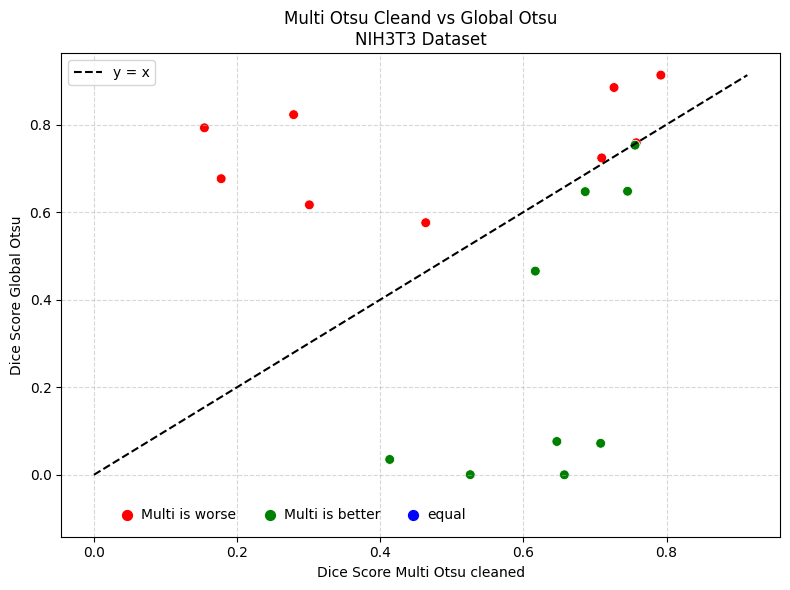

In [57]:
from src.multi import calculate_multiotsu_dice_scores_class1_cleaned


dice_all_nih_multi_cleand = calculate_multiotsu_dice_scores_class1_cleaned(imgs_NIH3T3, gts_NIH3T3)


scatterplot_without_regression(
    dice_all_nih_multi_cleand,
    dice_all_nih_global,
    xlabel="Dice Score Multi Otsu cleaned",
    ylabel="Dice Score Global Otsu",
    title="Multi Otsu Cleand vs Global Otsu\nNIH3T3 Dataset",
    label_red = "Multi is worse",
    label_green = "Multi is better",
    label_blue = "equal"
)

**2. Multi-Otsu with Cleaning and Small Object Removal**

In this final variant, we further extend the cleaning approach by also removing small connected components after thresholding. The intention is to eliminate isolated noise or residual artifacts that could skew the Dice score. We again compute Dice scores for the NIH3T3 dataset with `calculate_multiotsu_dice_scores_class1_cleaned_remove` and visualize the comparison to the global Otsu method to assess whether these refinements lead to a more consistent improvement.

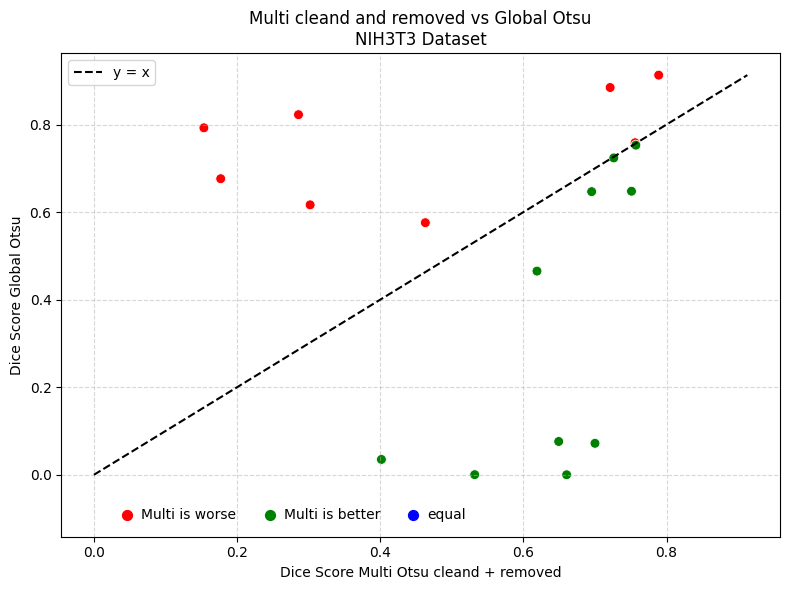

In [58]:
from src.multi import calculate_multiotsu_dice_scores_class1_cleaned_remove

dice_all_nih_multi_cleand_remove = calculate_multiotsu_dice_scores_class1_cleaned_remove(imgs_NIH3T3, gts_NIH3T3)

scatterplot_without_regression(
    dice_all_nih_multi_cleand_remove,
    dice_all_nih_global,
    xlabel="Dice Score Multi Otsu cleand + removed",
    ylabel="Dice Score Global Otsu",
    title="Multi cleand and removed vs Global Otsu\nNIH3T3 Dataset",
    label_red = "Multi is worse",
    label_green = "Multi is better",
    label_blue = "equal"
)

Despite these refinements, the overall performance trend did not improve significantly: approximately half of the images showed better segmentation with Multi-Otsu, while the other half performed worse. This inconsistency indicates that even with targeted cleaning and artifact removal, Multi-Otsu thresholding does not reliably outperform standard global Otsu on the NIH3T3 dataset. Based on these findings, we decided not to pursue Multi-Otsu-based segmentation further as a solution for flash artifact correction.

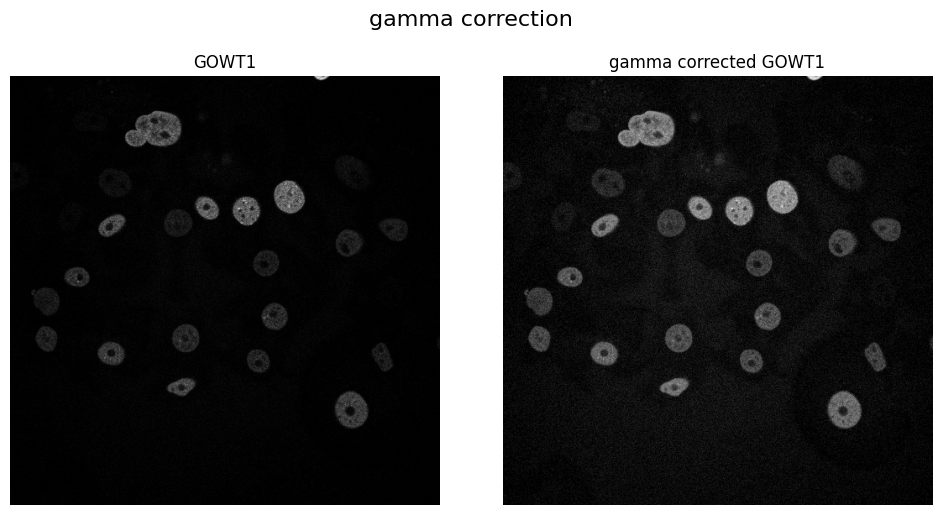

In [59]:
from src.pre_processing import gammacorrection

img_gowt1_gamma = gammacorrection(img_gowt1, gamma=0.6)

images_gamma = [img_gowt1, img_gowt1_gamma]
titles_img_gamma = ["GOWT1", "gamma corrected GOWT1"]

plot_images_fixed_size(images_gamma, titles=titles_img_gamma, main_title="gamma correction")

In [72]:
# import function for gamma correction + global otsu thresholding + dice score calculation
from src.Dice_Score_comparison import calculate_dice_scores_gamma_global

# apply gamma correction and global otsu thresholding on all images and calculate dice scores of each dataset 
dice_scores_N2DH_GOWT1_gamma_global = calculate_dice_scores_gamma_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_scores_N2DL_HeLa_gamma_global = calculate_dice_scores_gamma_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_NIH3T3_gamma_global = calculate_dice_scores_gamma_global(imgs_NIH3T3, gts_NIH3T3)


# vector with all dice score of gamma correction + global otsu thresholding
all_dice_scores_gamma_global =  dice_scores_N2DH_GOWT1_gamma_global + dice_scores_N2DL_HeLa_gamma_global + dice_scores_NIH3T3_gamma_global 

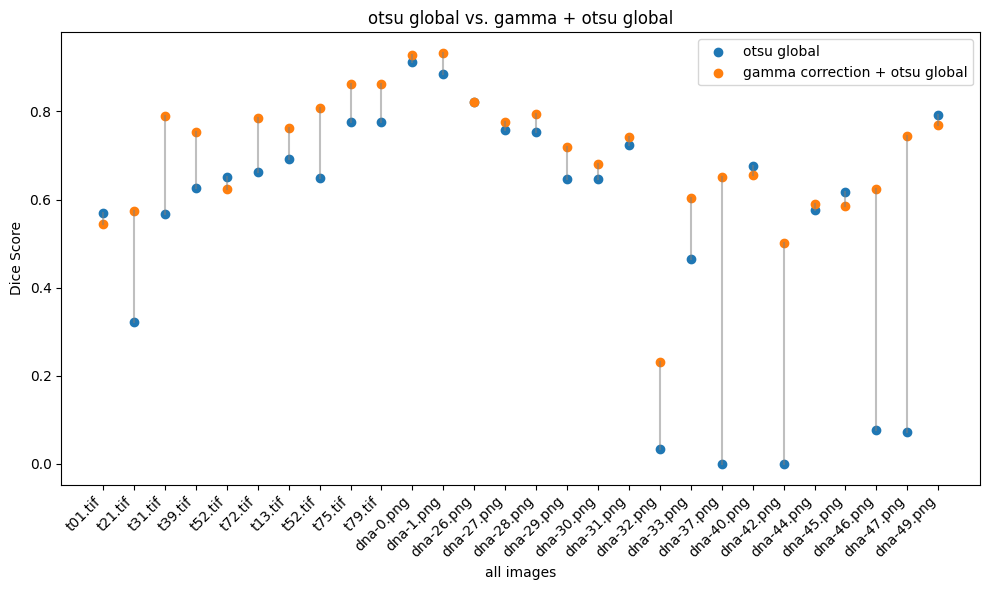

In [79]:
from src.Plots import plot_pairwise_scores
import numpy as np

# Spaghetti plot gamma correction + otsu global
# Datasets
labels = [
    # N2DH-GOWT1
    't01.tif', 't21.tif', 't31.tif', 't39.tif', 't52.tif', 't72.tif', 
     # N2DL-HeLa
    't13.tif', 't52.tif', 't75.tif', 't79.tif',     
      # NIH3T3                  
    'dna-0.png', 'dna-1.png', 'dna-26.png', 'dna-27.png',
    'dna-28.png', 'dna-29.png', 'dna-30.png', 'dna-31.png',
    'dna-32.png', 'dna-33.png', 'dna-37.png', 'dna-40.png',
    'dna-42.png', 'dna-44.png', 'dna-45.png', 'dna-46.png',
    'dna-47.png', 'dna-49.png'                                       
]

# Define indices for the labels of the later x-axis 
file_names = np.arange(len(labels))

plot_pairwise_scores(file_names, dice_all_global, all_dice_scores_gamma_global, 
                     labels=labels, 
                     title= "otsu global vs. gamma + otsu global", 
                     xlabel="all images", 
                     legend_labels=("otsu global", "gamma correction + otsu global")  )

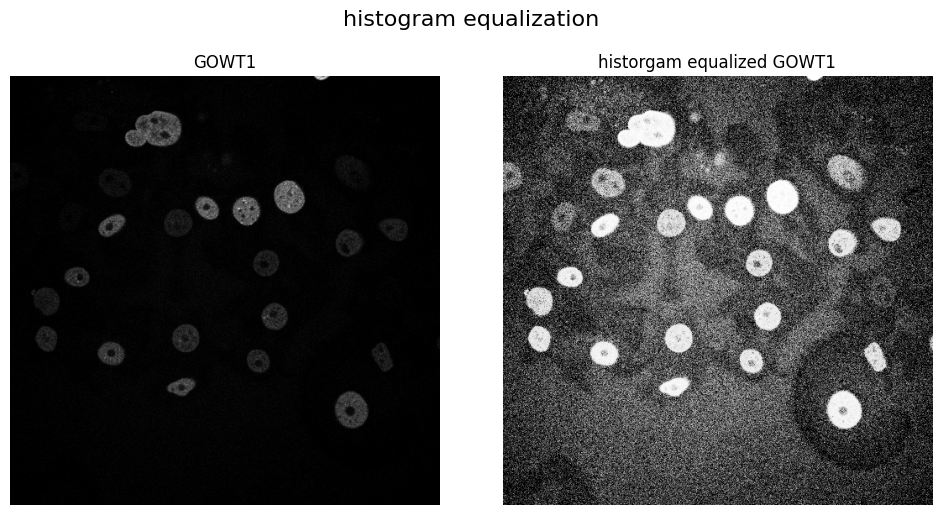

In [74]:
from src.pre_processing import histogramequalization

img_gowt1_histeq = histogramequalization(img_gowt1)

images_histeq = [img_gowt1, img_gowt1_histeq]
titles_img_histeq = ["GOWT1", "historgam equalized GOWT1"]

plot_images_fixed_size(images_histeq, titles=titles_img_histeq, main_title="histogram equalization")

In [ ]:
from src.Dice_Score_comparison import calculate_dice_scores_histeq_global

# apply histogram equalization and global otsu thresholding on all images and calculate dice scores of each dataset 
dice_scores_N2DH_GOWT1_histeq_global = calculate_dice_scores_histeq_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_scores_N2DL_HeLa_histeq_global = calculate_dice_scores_histeq_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_NIH3T3_histeq_global = calculate_dice_scores_histeq_global(imgs_NIH3T3, gts_NIH3T3)

# vector with all dice score of histogram equalization + global otsu thresholding
all_dice_scores_histeq_global =  dice_scores_N2DH_GOWT1_histeq_global + dice_scores_N2DL_HeLa_histeq_global + dice_scores_NIH3T3_histeq_global

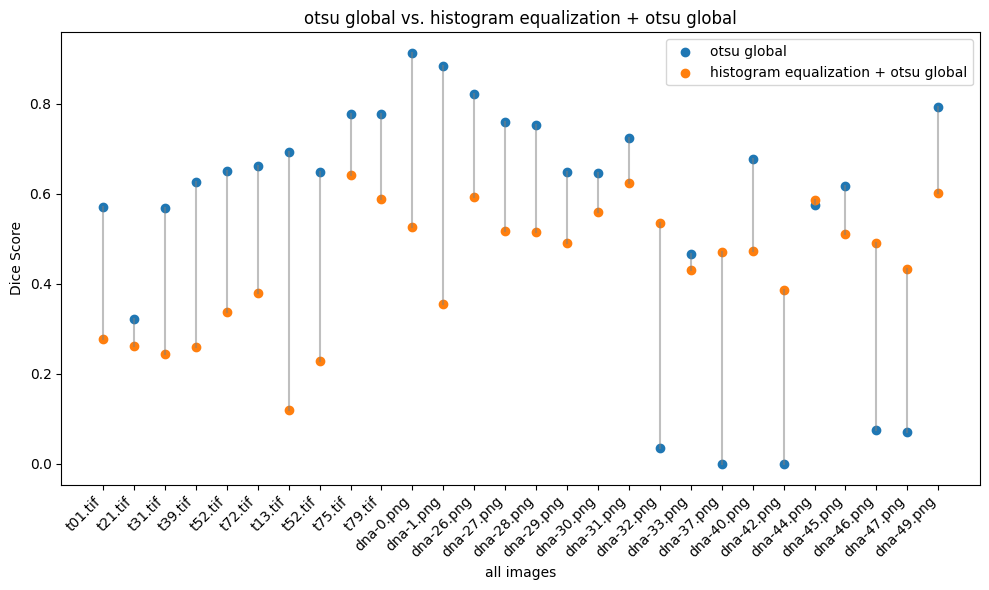

In [ ]:
# Define indices for the labels of the later x-axis 
file_names = np.arange(len(labels))

plot_pairwise_scores(file_names, dice_all_global, all_dice_scores_histeq_global, 
                     labels=labels, 
                     title= "otsu global vs. histogram equalization + otsu global", 
                     xlabel="all images", 
                     legend_labels=("otsu global", "histogram equalization + otsu global")  )

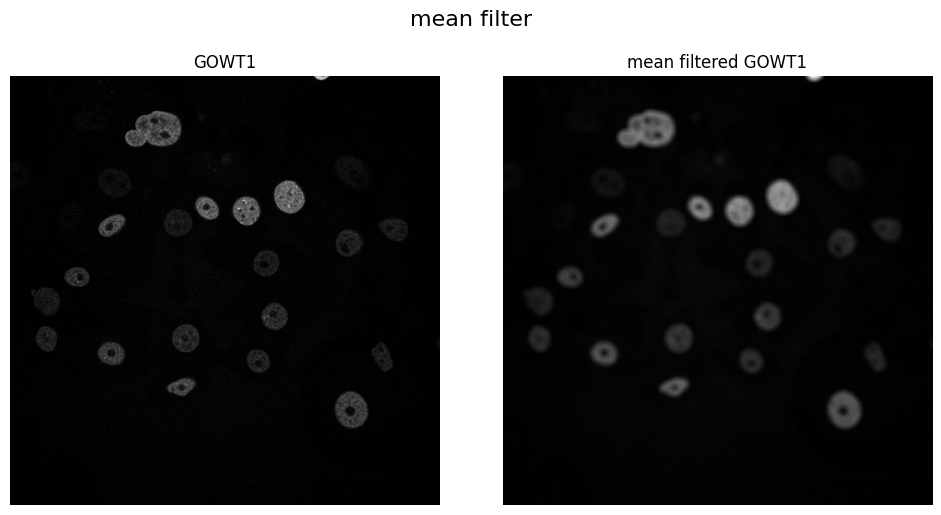

In [77]:
from src.pre_processing import mean_filter

img_gowt1_filtered = mean_filter(img_gowt1)

images_filtered = [img_gowt1, img_gowt1_filtered]
titles_img_histeq = ["GOWT1", "mean filtered GOWT1"]

plot_images_fixed_size(images_filtered, titles=titles_img_histeq, main_title="mean filter")

In [78]:
from src.Dice_Score_comparison import calculate_dice_scores_meanfilter_global

# apply mean filter and global otsu thresholding on all images and calculate dice scores of each dataset 
dice_scores_NIH3T3_meanfilter_global = calculate_dice_scores_meanfilter_global(imgs_NIH3T3, gts_NIH3T3)
dice_scores_N2DL_HeLa_meanfilter_global = calculate_dice_scores_meanfilter_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_N2DH_GOWT1_meanfilter_global = calculate_dice_scores_meanfilter_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)

# vector with all dice score of mean filter + global otsu thresholding
all_dice_scores_meanfilter_global =  dice_scores_N2DH_GOWT1_meanfilter_global + dice_scores_N2DL_HeLa_meanfilter_global + dice_scores_NIH3T3_meanfilter_global

In [ ]:
import importlib
import src.Dice_Score_comparison


importlib.reload(src.Dice_Score_comparison)

# Package Otsu Local for visualisation for time efficiency
from src.Dice_Score_comparison import calculate_dice_scores_otsu_package, calculate_dice_scores_local_package, calculate_package_dice_scores

# Compute Dice scores of Otsu Global package for each dataset
dice_all_gowt1_otsu_package = calculate_dice_scores_otsu_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_otsu_package = calculate_dice_scores_otsu_package(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_otsu_package = calculate_dice_scores_otsu_package(imgs_NIH3T3, gts_NIH3T3)

# Compute Dice scores of Otsu Lokal package for each dataset
dice_all_gowt1_local_package = calculate_dice_scores_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_local_package = calculate_dice_scores_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_local_package = calculate_dice_scores_local_package(imgs_NIH3T3, gts_NIH3T3)

# Compute package Dice scores of our Otsu Global for each dataset
package_dice_all_gowt1_global = calculate_package_dice_scores(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
package_dice_all_hela_global = calculate_package_dice_scores(imgs_N2DL_HeLa, gts_N2DL_HeLa)
package_dice_all_nih_global = calculate_package_dice_scores(imgs_NIH3T3, gts_NIH3T3)


# vector with all Dice scores with package Otsu Global (np.float64 values)
dice_all_otsu_package = dice_all_gowt1_otsu_package + dice_all_hela_otsu_package + dice_all_nih_otsu_package

# vector with all Dice scores with package Otsu Global (np.float64 values)
dice_all_local_package = dice_all_gowt1_local_package + dice_all_hela_local_package + dice_all_nih_local_package

# vector with all package Dice scores with our Otsu Global (np.float64 values)
package_dice_all_global = package_dice_all_gowt1_global + package_dice_all_hela_global + package_dice_all_nih_global

# vector with all Dice scores with our Otsu Global (float values)
dice_all_global = dice_all_gowt1_global + dice_all_hela_global + dice_all_nih_global

# vector with all Dice scores with our Otsu local (radius 15)
dice_all_local = dice_all_gowt1_local + dice_all_hela_local + dice_all_nih_local
# For the case that you have used package Local bevore
dice_all_local = [0.28915016099131624, 0.16063829075758015, 0.22105149983872702, 0.2231858373710903, 0.3088252523054779, 0.30119415014900364, 0.127401800392217, 0.22748756252516544, 0.8096747709543749, 0.8140793571650516, 0.29039299624199894, 0.33118018193464527, 0.4176239930846999, 0.4371394982478085, 0.3701623597067227, 0.3284172674518776, 0.43645741459967713, 0.5000010028581457, 0.4155832945477366, 0.35224958286077346, 0.38652755251439025, 0.3937666853205875, 0.33780649515453676, 0.499008725175988, 0.40156051427417766, 0.36125789077430936, 0.3048632763421365, 0.5034307768885828]

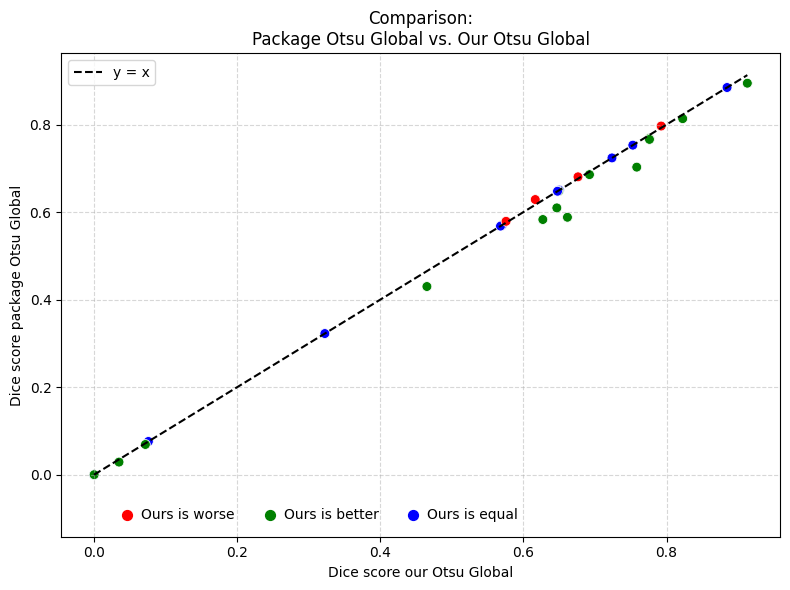

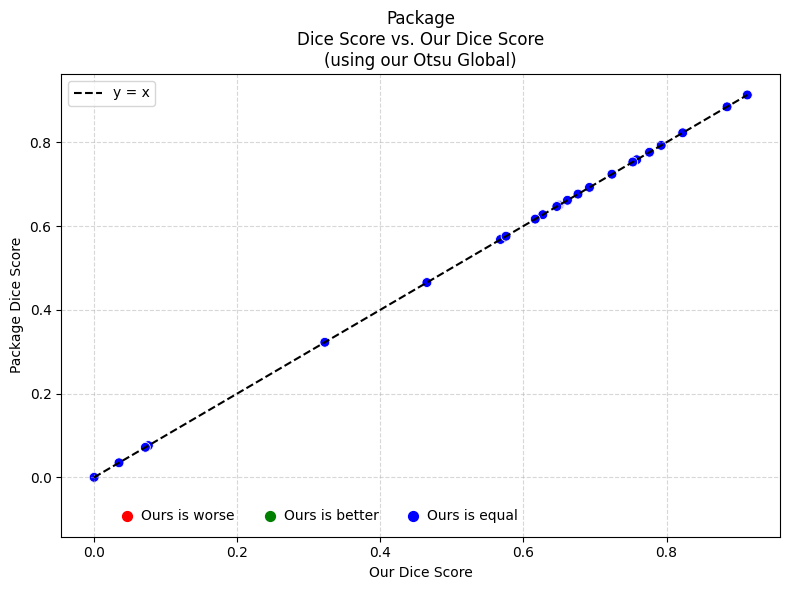

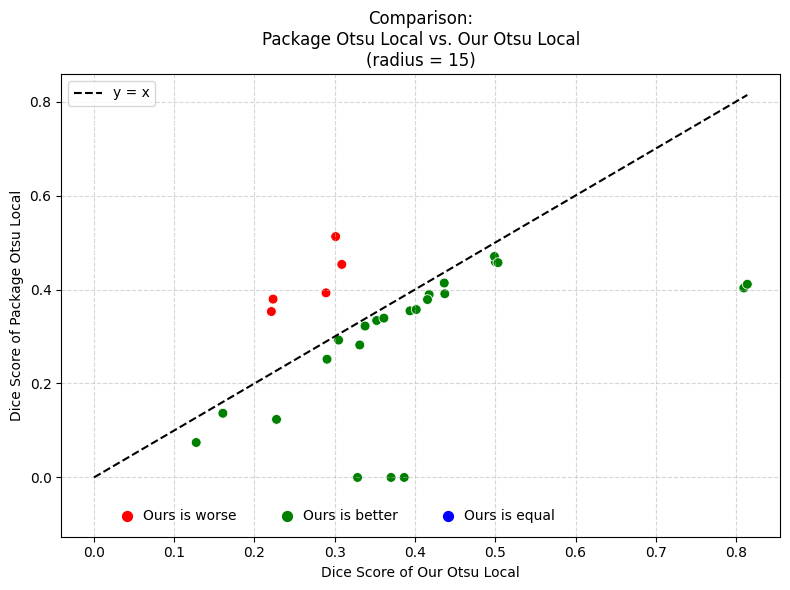

In [42]:
# Global vs Package Gloal
scatterplot_without_regression(
    dice_all_global,
    dice_all_otsu_package,
    xlabel="Dice score our Otsu Global",
    ylabel="Dice score package Otsu Global",
    title="Comparison:\nPackage Otsu Global vs. Our Otsu Global",
    label_red = "Ours is worse",
    label_green = "Ours is better",
    label_blue = "Ours is equal"
)

# Our Dice score vs Package Dice score
scatterplot_without_regression(
    dice_all_global,
    package_dice_all_global,
    xlabel="Our Dice Score",
    ylabel="Package Dice Score",
    title="Package\nDice Score vs. Our Dice Score\n(using our Otsu Global)",
    label_red = "Ours is worse",
    label_green = "Ours is better",
    label_blue = "Ours is equal"
)

# Our Dice score vs Package Dice score
scatterplot_without_regression(
    dice_all_local,
    dice_all_local_package,
    xlabel="Dice Score of Our Otsu Local",
    ylabel="Dice Score of Package Otsu Local",
    title="Comparison:\nPackage Otsu Local vs. Our Otsu Local\n(radius = 15)",
    label_red = "Ours is worse",
    label_green = "Ours is better",
    label_blue = "Ours is equal"
)

In [29]:
# calculate the best radius for local
import importlib

import src.Dice_Score_comparison
import src.radius_calculation


importlib.reload(src.radius_calculation)
from src.radius_calculation import calculate_best_radii_and_dice1


radii = list(range(1, 3000, 2))

results_gowt1_best_local_radius, results_gowt1_best_local_dice  = calculate_best_radii_and_dice1(imgs_N2DH_GOWT1, gts_N2DH_GOWT1, radii)
results_hela_best_local_radius, results_hela_best_local_dice  = calculate_best_radii_and_dice1(imgs_N2DL_HeLa, gts_N2DL_HeLa, radii)
results_nih_best_local_radius, results_nih_best_local_dice  = calculate_best_radii_and_dice1(imgs_NIH3T3, gts_NIH3T3, radii)


results_best_local_radius = results_gowt1_best_local_radius + results_hela_best_local_radius + results_nih_best_local_radius

print("Radius_with_best_Dice Score =", results_best_local_radius)

Processing images:   0%|          | 0/6 [00:39<?, ?it/s]


KeyboardInterrupt: 

In [31]:
# for tome efficiency otput of results_gowt1_best_local_radius:
results_gowt1_best_local_radius = [
    350.0, 550.0, 450.0, 450.0, 900.0, 100.0
]

# for tome efficiency otput of results_hela_best_local_radius:
results_hela_best_local_radius = [
    700.0, 200.0, 50.0, 50.0
]

# for tome efficiency otput of results_nih_best_local_radius:
results_nih_best_local_radius = [
    550.0, 500.0, 150.0, 100.0, 250.0, 150.0, 100.0, 100.0, 100.0, 150.0,
    100.0, 200.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0
]

results_best_local_radius = results_gowt1_best_local_radius + results_hela_best_local_radius + results_nih_best_local_radius

print("Radius_with_best_Dice Score =", results_best_local_radius)

Radius_with_best_Dice Score = [350.0, 550.0, 450.0, 450.0, 900.0, 100.0, 700.0, 200.0, 50.0, 50.0, 550.0, 500.0, 150.0, 100.0, 250.0, 150.0, 100.0, 100.0, 100.0, 150.0, 100.0, 200.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0]


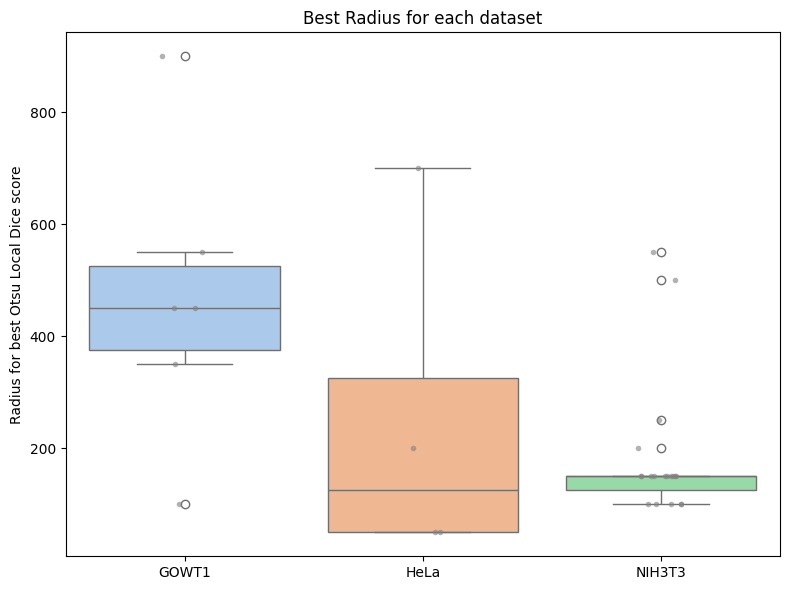

In [81]:
from src.Plots import plot_single_grouped_boxplot,combine_results_to_dataframe

df_all = combine_results_to_dataframe(
    names=["GOWT1", "HeLa", "NIH3T3"],
    lists=[results_gowt1_best_local_radius, results_hela_best_local_radius, results_nih_best_local_radius]
)

plot_single_grouped_boxplot(
    df=df_all,
    title="Best Radius for each dataset",
    ylabel="Radius for best Otsu Local Dice score"
)
